In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import wandb
import tempfile
import os
from models.normalizing_flow import HierarchicalNormalizingFlowSB
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn


In [25]:
import hamiltorch

In [26]:
from train_flow_sb import unflatten, object_from_config

In [27]:
api = wandb.Api()

In [28]:
run = api.run('druhe/gw-src/1l9zbsnf')


In [29]:
config = unflatten(run.config)

In [30]:
dataset = object_from_config(config, key='dataset')
dataset = dataset(**config['dataset'])

In [31]:
flows = object_from_config(config, key='flow')(**config['flow'])

In [32]:
checkpoints = [f for f in run.files() if f.name.endswith('.ckpt')]

In [33]:
tempdir = tempfile.TemporaryDirectory()

In [34]:
checkpoints = [f for f in run.files() if f.name.endswith('.pt')]

ckpt = checkpoints[-1]

ckpt_path = ckpt.download(root=tempdir.name, replace=True)

ckpt_path

<_io.TextIOWrapper name='/tmp/tmpkj5fuadp/epoch_500_step_513525_val_loss=8.3308.pt' mode='r' encoding='UTF-8'>

In [35]:
model = object_from_config(config, key='model')(flows=flows, dataset=dataset, prior_weight=1, sb_weight=0)

In [36]:
model.load_state_dict(torch.load(ckpt_path.name), strict=False)

model.eval()

HierarchicalNormalizingFlowSB(
  (trainable_flows): ModuleList(
    (0): Planar()
    (1): Planar()
    (2): Planar()
    (3): Planar()
    (4): Planar()
    (5): Planar()
    (6): Planar()
    (7): Planar()
    (8): Planar()
    (9): Planar()
  )
)

In [37]:
axes_names = []
axes = []

for n, ax in dataset.grid.items():
    axes_names.append(n)
    axes.append(ax)

d = dataset.dimensionality
m1, m2, z, chi = np.stack(np.meshgrid(*axes, indexing="ij")).reshape(d, -1)

resolutions = [len(ax) for ax in axes]

input = np.stack([m1, m2, z, chi], axis=-1)
input = torch.from_numpy(input).float()

In [38]:
with torch.no_grad():
    logprob = model.log_prob(input)
    prob = logprob.exp().view(*resolutions)

In [39]:
pm1m2 = prob.sum((2, 3)).cpu()

In [40]:
pm1 = pm1m2.sum(-1)

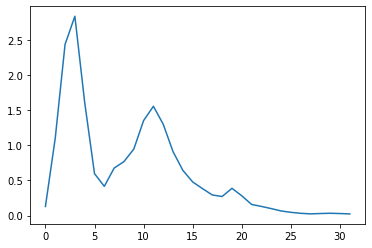

In [41]:
plt.plot(pm1)

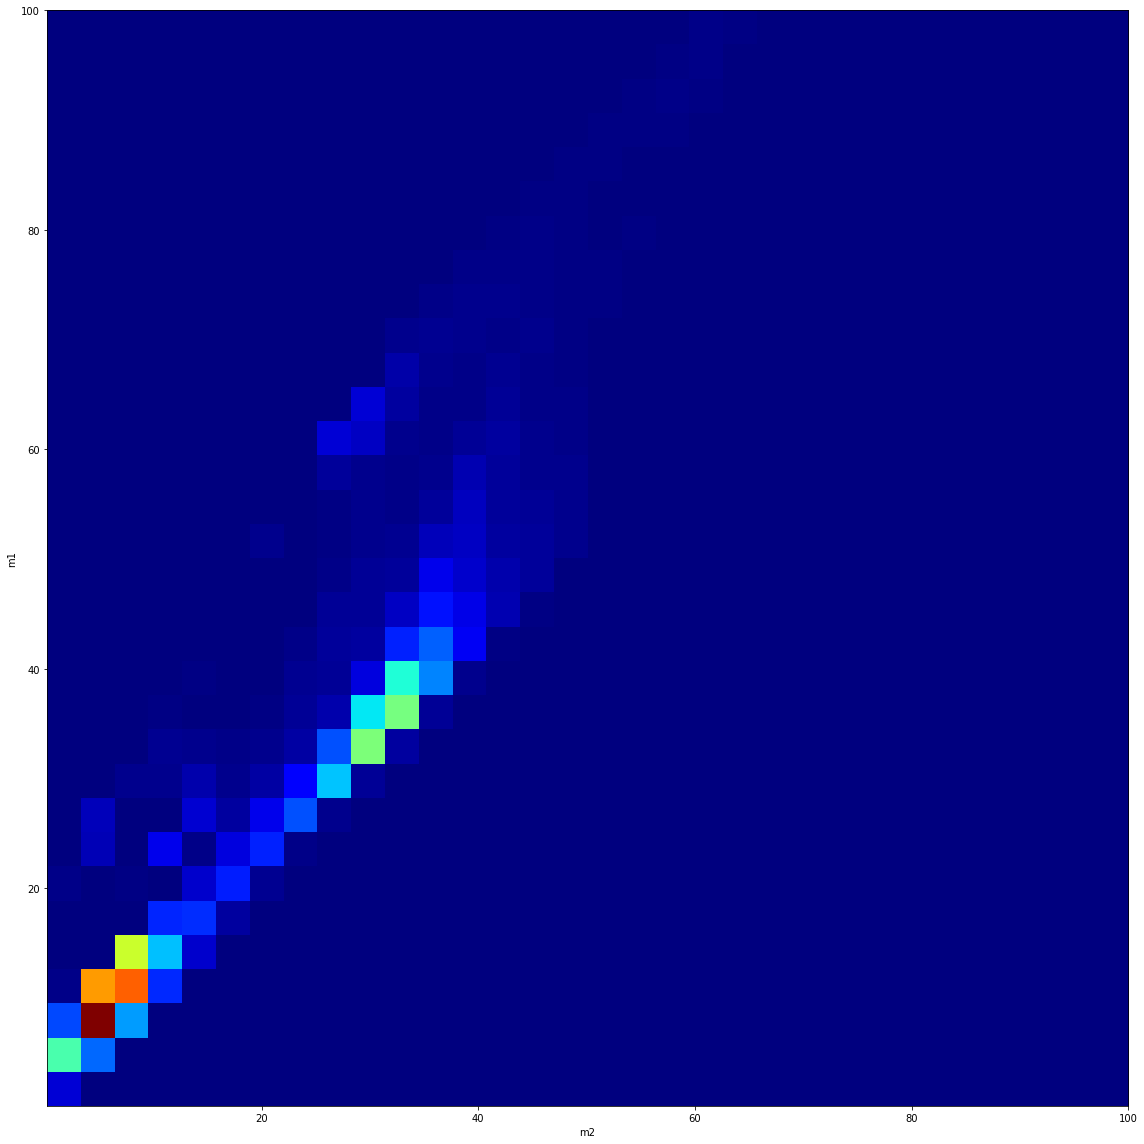

In [42]:
fig = plt.figure(figsize=(16, 16), facecolor="white")
plt.imshow(
    pm1m2,
    cmap="jet",
    origin="lower",
    extent=(
        axes[1][0],
        axes[1][-1],
        axes[0][0],
        axes[0][-1],
    ),  # origin='lower' changes the order
    aspect="auto",
)

plt.xlabel(axes_names[1])  # origin='lower' changes the order
plt.ylabel(axes_names[0])
plt.tight_layout()

In [43]:
def log_prob(x):
    x = x[None]
    return model.log_prob(x).sum()

In [22]:
v, _ = input.median(dim=0)

In [45]:
# ### L = 5
# step_size = .3
# N = 2048

# hamiltorch.set_random_seed(123)
# params_init = v
# burn=500
# N_nuts = burn + N
# params_hmc_nuts = hamiltorch.sample(log_prob_func=log_prob, params_init=params_init,
#                                                   num_samples=N_nuts,step_size=step_size,num_steps_per_sample=L,
#                                                   sampler=hamiltorch.Sampler.HMC_NUTS, burn=burn,
#                                                   desired_accept_rate=0.8)


# samples = torch.stack(params_hmc_nuts)

In [46]:
import seaborn as  sns

In [47]:
prop_shift = torch.tensor([-0.1, -0.1, 0, -0.5])
prop_scale = torch.tensor([100, 100, 10, 2])
max_log_prob = 0
n_dims = 4

# model = torch.distributions.Normal(0, 1)

@torch.no_grad()
def rejection_sampling(num_steps=1):
    """
    Perform rejection sampling on image distribution
    :param num_steps: Number of rejection sampling steps to perform
    :return: Accepted samples
    """
    eps = torch.rand((num_steps, n_dims))
    z_ = (eps + prop_shift) * prop_scale
    print(z_.min(0), z_.max(0))
    prob = torch.rand(num_steps)
    prob_ = torch.exp(model.log_prob(z_) - max_log_prob)
    
    accept = prob_ > prob
    z = z_[accept, :]
    return z

In [48]:
z = torch.zeros((0, n_dims))

In [49]:
while len(z) < 4096:
    z = torch.cat([z, rejection_sampling(2 ** 25)])
    print(len(z))

torch.return_types.min(
values=tensor([-10., -10.,   0.,  -1.]),
indices=tensor([19678587, 28368462,  9629267, 19739272])) torch.return_types.max(
values=tensor([90.0000, 90.0000, 10.0000,  1.0000]),
indices=tensor([ 5157257, 16058439,  7675982, 10529437]))
148
torch.return_types.min(
values=tensor([-10., -10.,   0.,  -1.]),
indices=tensor([12393078,  5208105,  1228433,  8798606])) torch.return_types.max(
values=tensor([90.0000, 90.0000, 10.0000,  1.0000]),
indices=tensor([14580904,  2140863,  2834172, 11970447]))
321
torch.return_types.min(
values=tensor([-10., -10.,   0.,  -1.]),
indices=tensor([ 2615929,  9500864, 20330769, 19702221])) torch.return_types.max(
values=tensor([90.0000, 90.0000, 10.0000,  1.0000]),
indices=tensor([ 2291722, 25704048, 13893243,  2752964]))
504
torch.return_types.min(
values=tensor([-10., -10.,   0.,  -1.]),
indices=tensor([ 9080604,  3648310,  2912833, 23024477])) torch.return_types.max(
values=tensor([90.0000, 90.0000, 10.0000,  1.0000]),
indices=tensor

In [50]:
z_q = z.clone()

In [51]:
z_q[:, 1] = z_q[:, 1] / z_q[:, 0]

In [52]:
z_q = z_q[z_q[:, 1] < 1]
z_q = z_q[z_q[:, 1] > 0]


In [53]:
z_q = z_q[z_q[:, 0] > 0]

In [54]:
import corner

INFO:matplotlib.mathtext:Substituting symbol X from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol X from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol X from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol X from STIXNonUnicode


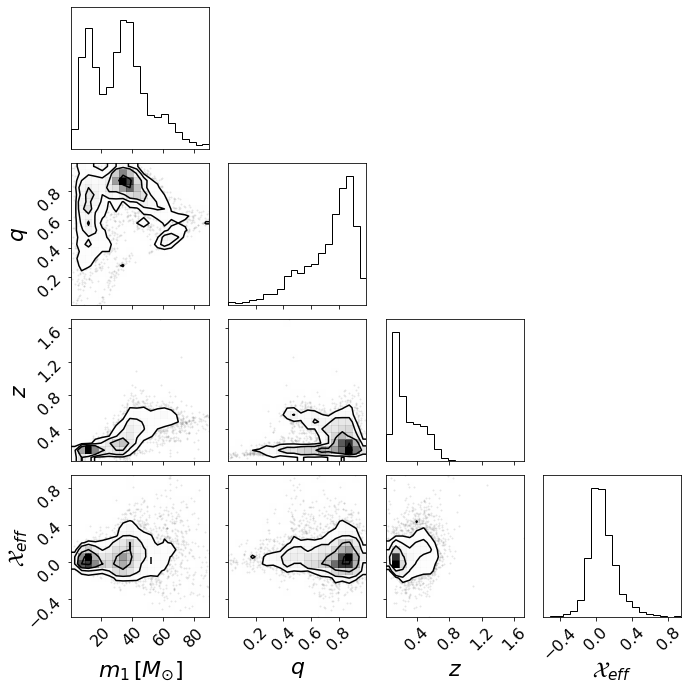

In [154]:
fig = corner.corner(z_q.numpy(), labels=[r"$m_1\, [M_{\odot}]$", r"$q$", r"$z$", r"$\mathcal{X}_{eff}$"], label_kwargs=dict(fontsize=22))

for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=16)
plt.tight_layout()

# fig.subplots_adjust(right=1.5,top=1.5)
plt.savefig('corner.pdf', bbox_inches='tight')





In [156]:
size = fig.get_size_inches()

In [157]:
size

array([9.7, 9.7])

In [139]:
xi_eff = z_q[:, 3]

In [140]:
q = z_q[:, 1]

In [141]:
q.shape

torch.Size([4168])

In [142]:
xi_eff.shape

torch.Size([4168])

INFO:matplotlib.mathtext:Substituting symbol X from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol X from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol X from STIXNonUnicode


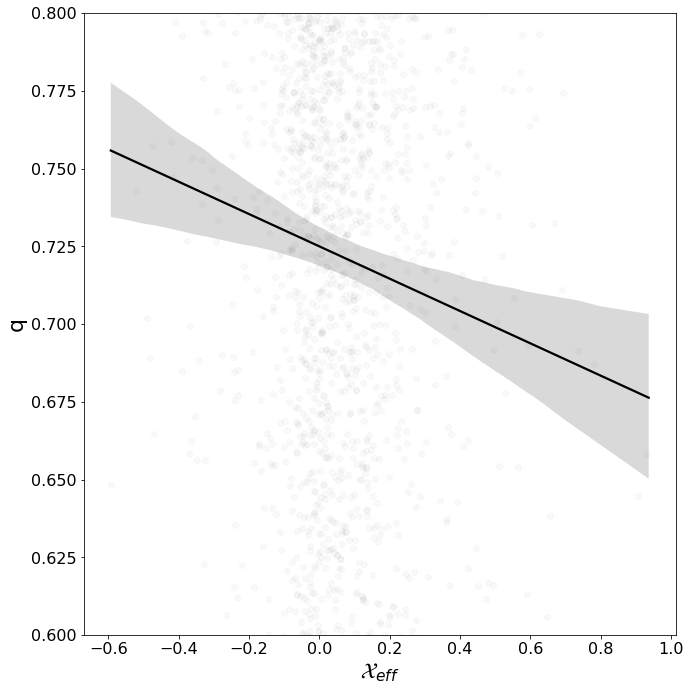

In [158]:
plt.figure(figsize=(9.7, 9.7))
sns.regplot(x=xi_eff.numpy(), y=q.numpy(), scatter_kws=dict(alpha=0.025), color='black')
plt.ylim((0.6, 0.8))
# sns.scatterplot(x=xi_eff.numpy(), y=q.numpy(), alpha=0.1)
# plt.close()
# sns.kdeplot(x=xi_eff.numpy(), y=q.numpy(), bw_adjust=0.1, fill=True, thresh=0.2)
plt.xlabel(r"$\mathcal{X}_{eff}$", fontsize=22)
plt.ylabel(r"q", fontsize=22)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.tight_layout()
plt.savefig('xi_q.pdf')


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

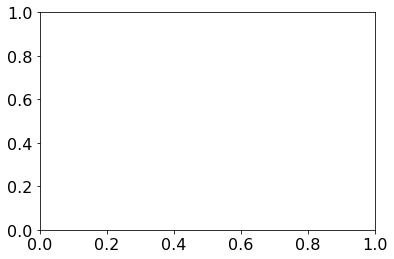

(array([ 1.,  1.,  2.,  7.,  7., 11., 11., 10., 24., 18., 24., 33., 26.,
        24., 33., 41., 37., 26., 28., 31., 31., 23., 30., 27., 27., 14.,
        17., 22., 23., 26., 25., 13., 27., 12., 15., 11., 11., 12., 19.,
        27., 29., 15., 26., 29., 19., 26., 36., 43., 47., 32., 46., 45.,
        46., 36., 36., 36., 27., 30., 33., 37., 29., 21., 24., 23., 20.,
        17., 20., 21., 12., 17., 20., 23., 14., 21., 18., 13.,  5.,  9.,
         9., 11., 10.,  8., 16., 11.,  6., 11.,  7.,  9., 11.,  8., 10.,
         8.,  5., 10., 11., 10., 11.,  9., 11.,  5.,  7.,  5.,  4.,  6.,
         9.,  1.,  4., 11.,  1.,  2.,  1.,  2.,  4.,  3.,  3.,  2.,  2.,
         2.,  1.,  2.,  2.,  2.,  0.,  4.,  1.,  0.,  0.,  1.]),
 array([ 0.28462037,  0.9593458 ,  1.6340712 ,  2.3087966 ,  2.9835222 ,
         3.6582475 ,  4.332973  ,  5.0076985 ,  5.6824236 ,  6.357149  ,
         7.0318747 ,  7.7066    ,  8.381326  ,  9.056051  ,  9.730777  ,
        10.405501  , 11.080227  , 11.754952  , 12.429678  ,

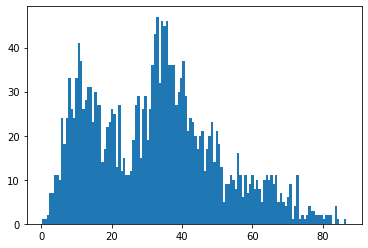

In [151]:
plt.hist(z_q[:, 0], bins=128)